# Credit Card Customer Segmentation

Jonathan Underwood - Spring 2024

https://github.com/jyunderwood/dtsa-5510-final

## Introduction

In this notebook, I will be exploring the Credit Card Dataset from Kaggle. The dataset is a sample of credit card holders during a six month period. The goal of this notebook is to segment the customers based on their credit card usage and other features. 

https://www.kaggle.com/datasets/arjunbhasin2013/ccdata

I will use K-Means and Hierarchical Clustering to segment the customers.

### Why this dataset?

I was interested in exploring a dataset that is related to my career, and not only is this dataset related to finance, it contains mostly numerical data which is perfect for exploring clustering.

### What's the problem I'm trying to solve?

There are a few different credit card usage patterns that I can think of from personal experience. Using a credit card only for emergencies, maybe only using one to make big purchases to pay off over time, or using a credit card for purchases and fully pay off their balance--maybe because you're trying to build credit or because you're trying to get rewards points.

I want to see if I can segment customers in this dataset to see if there are any patterns match my hunches and see if there are any other patterns that I didn't think of.


In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage

In [2]:
df = pd.read_csv('data/credit-cards.csv')
df_original = df.copy()

## EDA

In [3]:
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


In [4]:
df.isnull().sum()

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

There are 8950 rows and 18 columns in this dataset. `CREDIT_LIMIT` has a row with a null value. I'm going to replace it's null with the average. `MINIMUM_PAYMENTS` has about 3% of the data missing. My assumption is the missing values are due to the customer not having a minimum payment for that month. I will fill the missing values as 0 as that's the most likely scenario.

I'm also going to drop the `CUST_ID` column as it's not useful for clustering.

In [5]:
df['CREDIT_LIMIT'].fillna(df['CREDIT_LIMIT'].mean(), inplace=True)
df['MINIMUM_PAYMENTS'].fillna(0, inplace=True)

df.drop(columns=['CUST_ID'], inplace=True)

In [6]:
np.transpose(df.describe())

,count,mean,std,min,25%,50%,75%,max
BALANCE,8950.0,1564.474828,2081.531879,0.0,128.281915,873.385231,2054.140036,19043.13856
BALANCE_FREQUENCY,8950.0,0.877271,0.236904,0.0,0.888889,1.000000,1.000000,1.00000
PURCHASES,8950.0,1003.204834,2136.634782,0.0,39.635000,361.280000,1110.130000,49039.57000
ONEOFF_PURCHASES,8950.0,592.437371,1659.887917,0.0,0.000000,38.000000,577.405000,40761.25000
INSTALLMENTS_PURCHASES,8950.0,411.067645,904.338115,0.0,0.000000,89.000000,468.637500,22500.00000
CASH_ADVANCE,8950.0,978.871112,2097.163877,0.0,0.000000,0.000000,1113.821139,47137.21176
PURCHASES_FREQUENCY,8950.0,0.490351,0.401371,0.0,0.083333,0.500000,0.916667,1.00000
ONEOFF_PURCHASES_FREQUENCY,8950.0,0.202458,0.298336,0.0,0.000000,0.083333,0.300000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,8950.0,0.364437,0.397448,0.0,0.000000,0.166667,0.750000,1.00000
CASH_ADVANCE_FREQUENCY,8950.0,0.135144,0.200121,0.0,0.000000,0.000000,0.222222,1.50000


There are also some columns I don't think are useful. Tenure, for example, is the number of months the customer has had the credit card and maxes out at 12. Any of the Frequency columns are also not useful either as from the description on kaggle, they are based on how often the data was reported. 

In [7]:
columns_to_drop = ["TENURE", "BALANCE_FREQUENCY", "PURCHASES_FREQUENCY", "ONEOFF_PURCHASES_FREQUENCY", "PURCHASES_INSTALLMENTS_FREQUENCY", "CASH_ADVANCE_FREQUENCY"]
df = df.drop(columns=columns_to_drop)

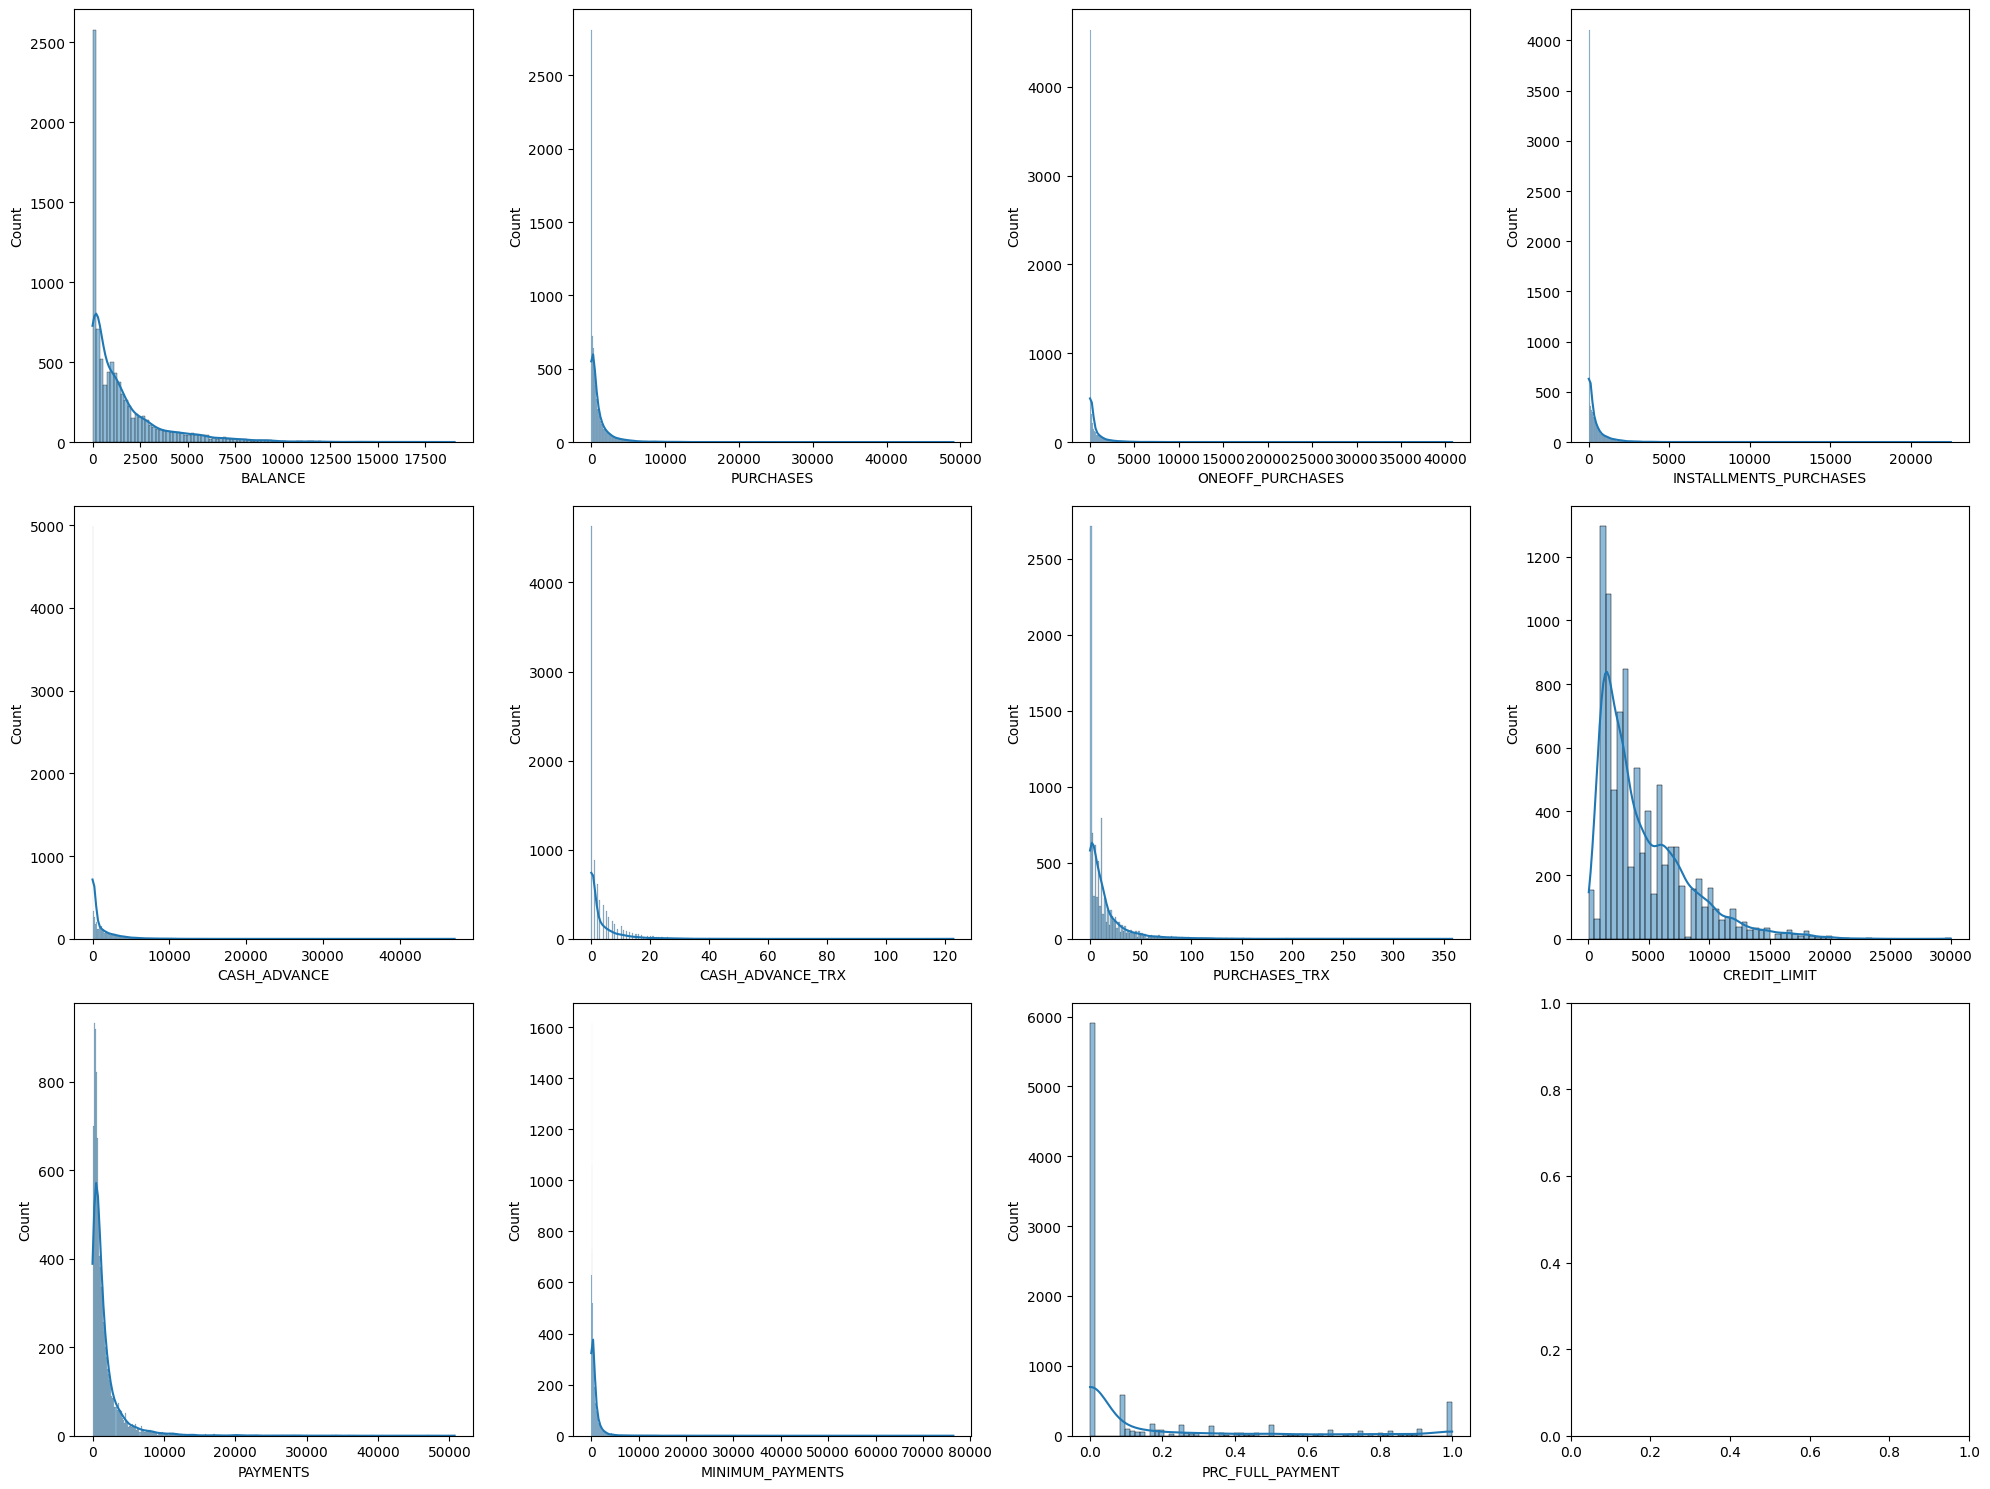

In [8]:
num_plots = len(df.columns)
num_cols = 4
num_rows = (
    num_plots // num_cols if num_plots % num_cols == 0 else num_plots // num_cols + 1
)

fig, axs = plt.subplots(num_rows, num_cols, figsize=(num_cols * 5, num_rows * 5))

for i, col in enumerate(df.columns):
    row = i // num_cols
    pos = i % num_cols
    sns.histplot(df[col], kde=True, ax=axs[row][pos])

plt.tight_layout()
plt.show()

In [9]:
skewness = df.skew()
print(skewness)

BALANCE                    2.393386
PURCHASES                  8.144269
ONEOFF_PURCHASES          10.045083
INSTALLMENTS_PURCHASES     7.299120
CASH_ADVANCE               5.166609
CASH_ADVANCE_TRX           5.721298
PURCHASES_TRX              4.630655
CREDIT_LIMIT               1.522549
PAYMENTS                   5.907620
MINIMUM_PAYMENTS          13.808430
PRC_FULL_PAYMENT           1.942820
dtype: float64


In [10]:
for col in df.columns:
    if skewness[col] > 1:
        df[col] = np.log1p(df[col])

df.skew()

BALANCE                  -0.861021
PURCHASES                -0.764492
ONEOFF_PURCHASES          0.185854
INSTALLMENTS_PURCHASES   -0.024981
CASH_ADVANCE              0.262594
CASH_ADVANCE_TRX          0.940131
PURCHASES_TRX             0.032697
CREDIT_LIMIT             -0.101564
PAYMENTS                 -1.778312
MINIMUM_PAYMENTS         -1.291787
PRC_FULL_PAYMENT          1.746046
dtype: float64

## Analysis

In week 2 we covered Distortion (means of square distance) and Inertia (sum of square distance) as a way to measure the quality of a clustering. I used Intertia determine the best number of clusters for K-Means.

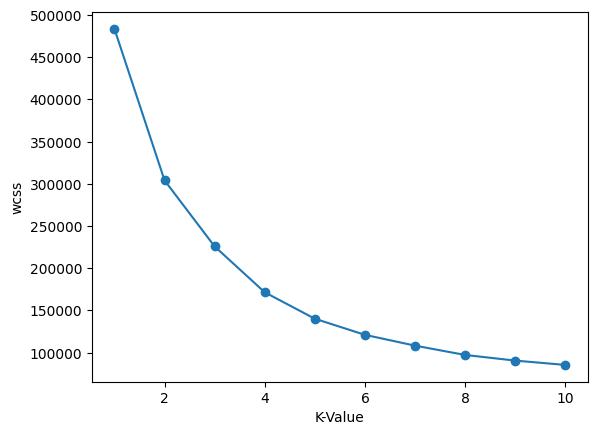

In [11]:
num_of_features = len(df.columns)

wcss = []
for i in range(1, num_of_features):
    km = KMeans(n_clusters=i, init="k-means++", n_init=10, max_iter=300, random_state=42)
    km.fit(df)
    wcss.append(km.inertia_)

plt.plot(range(1, num_of_features), wcss, marker="o")
plt.xlabel("K-Value")
plt.ylabel("wcss")
plt.show()

I decided to use 5 clusters based on the elbow method.

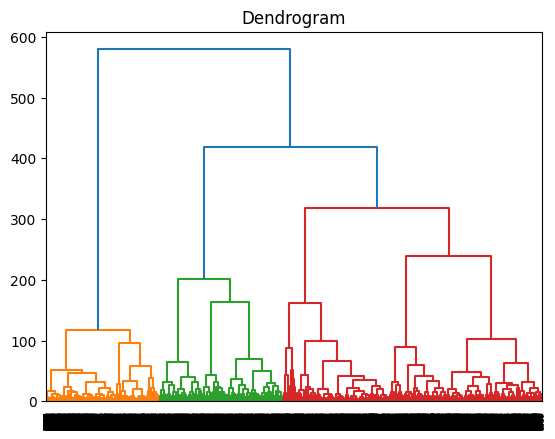

In [12]:
linkage_matrix = linkage(y=df , method='ward', metric='euclidean')
dendrogram(linkage_matrix, orientation='top')

plt.title('Dendrogram')
plt.show()

And the Dendrogram showed that 4 clusters would be a good number for Hierarchical Clustering.

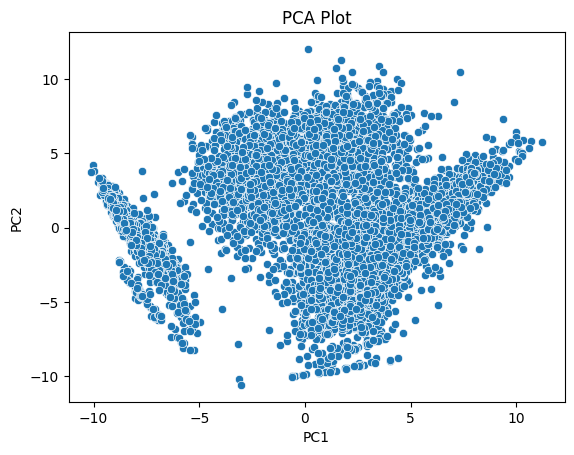

In [13]:
pca = PCA()
df_pca = pd.DataFrame(pca.fit_transform(df), columns=[f'PC{i}' for i in range(1, len(df.columns) + 1)])

sns.scatterplot(x='PC1', y='PC2', data=df_pca)
plt.title('PCA Plot')
plt.show()

To visualize the data, I used t-SNE (t-Distributed Stochastic Neighbor Embedding). It is used to visual high-dimensional data in low-dimensional space. SKLearn has a t-SNE implementation that I used to visualize the clusters.

- https://en.wikipedia.org/wiki/T-distributed_stochastic_neighbor_embedding
- https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html

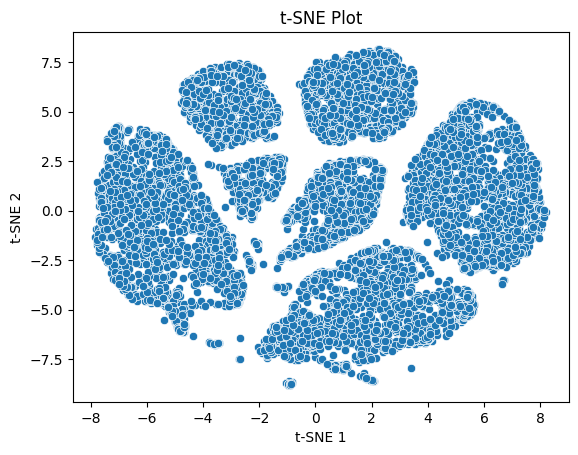

In [14]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=0.1, n_iter=2000)
X_tsne = tsne.fit_transform(df)
df_tsne = pd.DataFrame(data=X_tsne, columns=['t-SNE 1', 't-SNE 2'])

sns.scatterplot(x='t-SNE 1', y='t-SNE 2', data=df_tsne)
plt.title('t-SNE Plot')
plt.show()

When visualizing the clusters, I saw seven distinct clusters, so I ended up using 7 as my number of clusters for K-Means and Hierarchical Clustering.

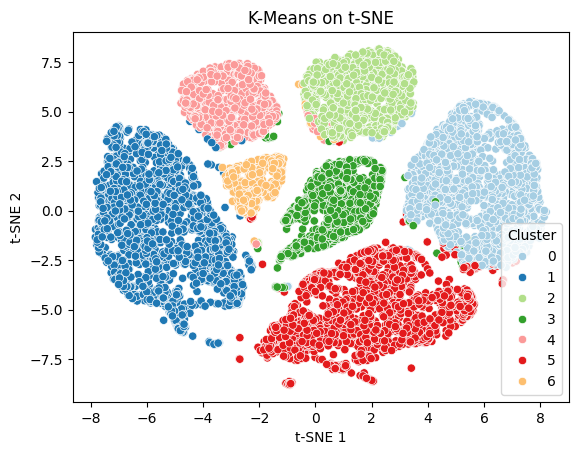

In [15]:
k_k = 7
k_model = KMeans(n_clusters=k_k, n_init=10, max_iter=300, random_state=42)
k_model.fit(df)
df_tsne["Cluster"] = k_model.labels_

sns.scatterplot(x="t-SNE 1", y="t-SNE 2", hue="Cluster", data=df_tsne, palette="Paired")
plt.title("K-Means on t-SNE")
plt.show()

With K-Means, there were still some overlap between the clusters. I used Hierarchical Clustering to see if I could get better separation between the clusters.

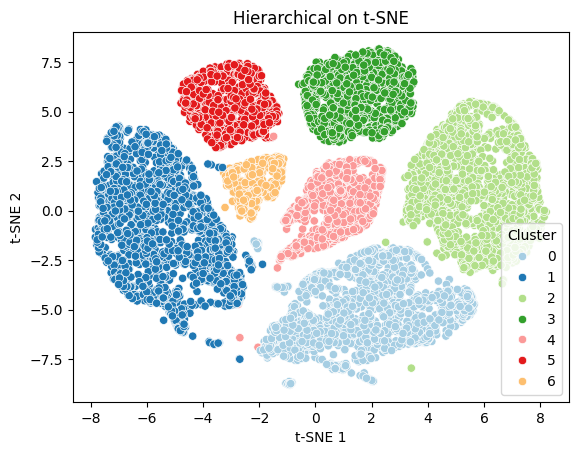

In [16]:
h_k = 7
h_model = AgglomerativeClustering(n_clusters=h_k)
h_model.fit(df)
df_tsne["Cluster"] = h_model.labels_

sns.scatterplot(x="t-SNE 1", y="t-SNE 2", hue="Cluster", data=df_tsne, palette="Paired")
plt.title("Hierarchical on t-SNE")
plt.show()

And I did seen better separation. Hierarchical Clustering was able to separate the clusters better than K-Means.

## Results

In [17]:
df_original['Cluster'] = h_model.labels_
df_original['Cluster'].value_counts()

Cluster
1    2057
0    1908
2    1733
4    1027
3    1004
5     767
6     454
Name: count, dtype: int64

Below are the results of the clustering.

There were 4 stand out groups:

- Cluster 0 - Only makes minimum payments
- Cluster 1 - Primary used their credit cards for cash advances
- Cluster 2 - Making dozens of purchases a month and paying quite a bit more than the minimum
- Cluster 4 - Makes one-off purchases and pays off over time

In [18]:
for i in range(h_k):
    print(f'Cluster {i}')
    display(np.transpose(df_original[df_original['Cluster'] == i].describe()))

Cluster 0


,count,mean,std,min,25%,50%,75%,max
BALANCE,1908.0,435.698643,990.392660,0.000000,18.543887,58.698932,339.863014,11670.179850
BALANCE_FREQUENCY,1908.0,0.780103,0.307975,0.000000,0.571429,1.000000,1.000000,1.000000
PURCHASES,1908.0,553.340314,902.859439,9.280000,154.805000,325.920000,617.812500,22500.000000
ONEOFF_PURCHASES,1908.0,36.791158,259.624929,0.000000,0.000000,0.000000,0.000000,6761.290000
INSTALLMENTS_PURCHASES,1908.0,517.500975,873.683658,0.000000,138.880000,306.675000,586.792500,22500.000000
CASH_ADVANCE,1908.0,30.104237,316.204807,0.000000,0.000000,0.000000,0.000000,7616.064965
PURCHASES_FREQUENCY,1908.0,0.687627,0.317473,0.083333,0.416667,0.788889,1.000000,1.000000
ONEOFF_PURCHASES_FREQUENCY,1908.0,0.016121,0.097233,0.000000,0.000000,0.000000,0.000000,1.000000
PURCHASES_INSTALLMENTS_FREQUENCY,1908.0,0.643555,0.330196,0.000000,0.333333,0.738636,1.000000,1.000000
CASH_ADVANCE_FREQUENCY,1908.0,0.004228,0.040874,0.000000,0.000000,0.000000,0.000000,1.000000


Cluster 1


,count,mean,std,min,25%,50%,75%,max
BALANCE,2057.0,2154.723856,2124.332707,0.00000,745.774052,1454.551875,2847.472954,14581.459140
BALANCE_FREQUENCY,2057.0,0.881828,0.233438,0.00000,0.900000,1.000000,1.000000,1.000000
PURCHASES,2057.0,0.029008,0.642500,0.00000,0.000000,0.000000,0.000000,18.350000
ONEOFF_PURCHASES,2057.0,0.003009,0.064049,0.00000,0.000000,0.000000,0.000000,2.000000
INSTALLMENTS_PURCHASES,2057.0,0.068269,1.667194,0.00000,0.000000,0.000000,0.000000,66.950000
CASH_ADVANCE,2057.0,2005.937274,2516.051789,0.00000,378.769414,1204.068667,2710.056224,26194.049540
PURCHASES_FREQUENCY,2057.0,0.000854,0.012861,0.00000,0.000000,0.000000,0.000000,0.416667
ONEOFF_PURCHASES_FREQUENCY,2057.0,0.000449,0.006660,0.00000,0.000000,0.000000,0.000000,0.166667
PURCHASES_INSTALLMENTS_FREQUENCY,2057.0,0.000486,0.011016,0.00000,0.000000,0.000000,0.000000,0.416667
CASH_ADVANCE_FREQUENCY,2057.0,0.272094,0.200898,0.00000,0.090909,0.250000,0.333333,1.500000


Cluster 2


,count,mean,std,min,25%,50%,75%,max
BALANCE,1733.0,1222.353303,1820.933303,0.000000,168.539199,535.278586,1518.339584,19043.13856
BALANCE_FREQUENCY,1733.0,0.935775,0.154623,0.000000,1.000000,1.000000,1.000000,1.00000
PURCHASES,1733.0,2477.001668,3507.443076,34.000000,736.240000,1534.120000,2855.040000,41050.40000
ONEOFF_PURCHASES,1733.0,1515.379083,2789.980726,5.000000,265.600000,765.850000,1744.630000,40624.06000
INSTALLMENTS_PURCHASES,1733.0,961.650860,1340.493612,6.330000,229.130000,545.050000,1174.000000,15497.19000
CASH_ADVANCE,1733.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
PURCHASES_FREQUENCY,1733.0,0.813105,0.237410,0.083333,0.666667,0.916667,1.000000,1.00000
ONEOFF_PURCHASES_FREQUENCY,1733.0,0.460625,0.332536,0.083333,0.166667,0.363636,0.750000,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,1733.0,0.647746,0.312107,0.083333,0.416667,0.666667,1.000000,1.00000
CASH_ADVANCE_FREQUENCY,1733.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000


Cluster 3


,count,mean,std,min,25%,50%,75%,max
BALANCE,1004.0,2822.777248,2608.350155,2.299436,891.605396,2003.855857,4005.732719,16259.44857
BALANCE_FREQUENCY,1004.0,0.969882,0.090175,0.181818,1.000000,1.000000,1.000000,1.00000
PURCHASES,1004.0,1940.274124,2543.725037,64.820000,612.172500,1240.290000,2394.680000,49039.57000
ONEOFF_PURCHASES,1004.0,1166.586046,1943.786557,8.900000,227.877500,616.625000,1402.025000,40761.25000
INSTALLMENTS_PURCHASES,1004.0,773.994024,1039.599645,9.650000,185.335000,447.230000,1019.610000,13184.43000
CASH_ADVANCE,1004.0,2090.814775,3117.372266,14.222216,399.128295,1116.127769,2646.855311,47137.21176
PURCHASES_FREQUENCY,1004.0,0.780054,0.245020,0.083333,0.583333,0.875000,1.000000,1.00000
ONEOFF_PURCHASES_FREQUENCY,1004.0,0.397291,0.289230,0.083333,0.166667,0.333333,0.583333,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,1004.0,0.629895,0.308755,0.083333,0.375000,0.666667,0.916667,1.00000
CASH_ADVANCE_FREQUENCY,1004.0,0.292146,0.213668,0.083333,0.083333,0.250000,0.416667,1.00000


Cluster 4


,count,mean,std,min,25%,50%,75%,max
BALANCE,1027.0,773.633960,1190.459218,0.000000,49.000223,259.467265,1096.588923,12323.845360
BALANCE_FREQUENCY,1027.0,0.780572,0.293006,0.000000,0.545455,1.000000,1.000000,1.000000
PURCHASES,1027.0,894.723486,1426.630583,0.000000,155.945000,450.000000,1026.205000,17945.000000
ONEOFF_PURCHASES,1027.0,894.808374,1426.610450,0.000000,155.945000,450.000000,1026.205000,17945.000000
INSTALLMENTS_PURCHASES,1027.0,0.006573,0.161614,0.000000,0.000000,0.000000,0.000000,4.800000
CASH_ADVANCE,1027.0,0.374943,6.440690,0.000000,0.000000,0.000000,0.000000,149.167024
PURCHASES_FREQUENCY,1027.0,0.360260,0.314593,0.083333,0.083333,0.250000,0.545455,1.000000
ONEOFF_PURCHASES_FREQUENCY,1027.0,0.359529,0.314988,0.000000,0.083333,0.250000,0.545455,1.000000
PURCHASES_INSTALLMENTS_FREQUENCY,1027.0,0.000487,0.011027,0.000000,0.000000,0.000000,0.000000,0.333333
CASH_ADVANCE_FREQUENCY,1027.0,0.000541,0.008655,0.000000,0.000000,0.000000,0.000000,0.222222


Cluster 5


,count,mean,std,min,25%,50%,75%,max
BALANCE,767.0,2386.370783,2288.783522,16.834929,864.392769,1636.518315,3163.428544,15258.22590
BALANCE_FREQUENCY,767.0,0.935584,0.148530,0.181818,1.000000,1.000000,1.000000,1.00000
PURCHASES,767.0,672.361747,1529.528822,8.400000,115.245000,293.260000,724.055000,22101.78000
ONEOFF_PURCHASES,767.0,672.407014,1529.510824,8.400000,115.245000,293.260000,724.055000,22101.78000
INSTALLMENTS_PURCHASES,767.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
CASH_ADVANCE,767.0,2052.596593,2505.332025,18.427395,371.352320,1162.045833,2773.220946,20277.33112
PURCHASES_FREQUENCY,767.0,0.278488,0.253110,0.083333,0.083333,0.166667,0.333333,1.00000
ONEOFF_PURCHASES_FREQUENCY,767.0,0.278380,0.253176,0.083333,0.083333,0.166667,0.333333,1.00000
PURCHASES_INSTALLMENTS_FREQUENCY,767.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
CASH_ADVANCE_FREQUENCY,767.0,0.298570,0.213941,0.083333,0.166667,0.250000,0.416667,1.25000


Cluster 6


,count,mean,std,min,25%,50%,75%,max
BALANCE,454.0,2557.697416,2591.826842,1.097736,880.815320,1639.426193,3326.503679,16304.889250
BALANCE_FREQUENCY,454.0,0.957081,0.125043,0.181818,1.000000,1.000000,1.000000,1.000000
PURCHASES,454.0,545.349515,851.939899,7.260000,161.840000,343.235000,658.485000,14686.100000
ONEOFF_PURCHASES,454.0,0.004471,0.066303,0.000000,0.000000,0.000000,0.000000,1.000000
INSTALLMENTS_PURCHASES,454.0,546.003172,851.849973,7.260000,161.840000,344.410000,658.485000,14686.100000
CASH_ADVANCE,454.0,1989.735493,2338.112270,18.531069,498.175954,1126.126871,2634.017583,17661.494860
PURCHASES_FREQUENCY,454.0,0.658623,0.311987,0.083333,0.416667,0.750000,1.000000,1.000000
ONEOFF_PURCHASES_FREQUENCY,454.0,0.000918,0.010318,0.000000,0.000000,0.000000,0.000000,0.166667
PURCHASES_INSTALLMENTS_FREQUENCY,454.0,0.610908,0.313609,0.083333,0.333333,0.666667,0.914773,1.000000
CASH_ADVANCE_FREQUENCY,454.0,0.261898,0.195042,0.083333,0.083333,0.166667,0.333333,1.000000
